In [14]:
import sys
sys.path.insert(0, "/home/cerasole/agnpy/")

# to be included in the photo_meson.py script
import numpy as np
import astropy.units as u
from astropy.constants import c, h, m_p
from agnpy.photo_meson.kernels import PhiKernel, secondaries, eta_0
from agnpy.utils.math import axes_reshaper, ftiny, fmax
from agnpy.utils.conversion import mpc2

# to be used only for the the validation
from astropy.modeling.models import BlackBody
import matplotlib.pyplot as plt
from agnpy.emission_regions import Blob
from agnpy.spectra import PowerLaw, ExpCutoffPowerLaw

In [12]:
def log10(x):
    """clipped log to avoid RuntimeWarning: divide by zero encountered in log"""
    values = np.clip(x, ftiny, fmax)
    return np.log10(values)

In [3]:
# Blob with proton population
E_star = 3e20 * u.Unit("eV")
gamma_star = (E_star / mpc2).to_value("")
k_p, p_p, gamma_c, gamma_min, gamma_max = 20.154 * u.Unit("cm-3"), 2, 1e3*gamma_star, 1, 1e6*gamma_star
n_p = ExpCutoffPowerLaw(k_p, p_p, gamma_c, gamma_min, gamma_max, mass = m_p)
blob = Blob(n_p = n_p)
print ("Proton energy density = ", blob.u_p)

Proton energy density =  1.0015136343290778 erg / cm3


In [4]:
class BlackbodyTarget:
    
    def __init__(self, T):
        self.T = T
        self.bb = BlackBody(T)
        
    def __call__(self, nu):
        return (
            4. * np.pi * u.Unit("sr") * self.bb(nu)
            / (c * h**2 * nu)
        ).to("cm-3 erg-1")

In [9]:
cmb_target = BlackbodyTarget(T = 2.7 * u.Unit("K"))

In [6]:
class PhotoMesonProduction:
    """Class for computation of the energetic spectra of secondaries of photomeson interactions.

    Parameters
    ----------
    blob : :class:`~agnpy.emission_region.Blob`
        emitting region with a proton distribution
    target : ...TBD...
        ...TBD...
    integrator : func
        function to be used for integration (default = `np.trapz`)
    """

    def __init__(
        self,
        blob,
        target,
        integrator=np.trapz
    ):
        self.blob = blob
        # check that this blob has a proton distribution
        if self.blob._n_p is None:
            raise AttributeError(
                "There is no proton distribution in this emission region"
            )
        self.target = target
        self.integrator = integrator
        return
        
        
    def H(
        self,
        eta,
        E, 
        phi_kernel,
        integrator = np.trapz
    ):
        """ Compute the H function in Eq. (70) [KelnerAharonian2008]_.

        Parameters
        ----------
        E : :class:`~astropy.units.Quantity`
            energy of the secondary particles
        eta : float
            kinematic variable (:math:`eta = 4 \epsilon \gamma_{\rm p}`)
        phi_kernel : `~agnpy.photo_meson.PhiKernel`
            kernel to be used for the integration (depends on the particle)
        integrator : func
            function to be used for integration (default = `np.trapz`)
        """        
        # Integral on E_p to be made from E to infinity
        _eta, _E = axes_reshaper(eta, E)   # shape (len(eta), 1), (1, len(E))
        _E_p = np.logspace(
            log10(_E.to_value("eV")), 
            log10(_E.to_value("eV")) + 8, 
            200
        ) * u.Unit("eV")                   # shape (200, 1, len(E))
        _gamma_p = _E_p / mpc2
        _epsilon = _eta * mpc2**2 / (4*_E_p)
        _nu = _epsilon / h
        _x = _E / _E_p
        _H_integrand = (
            mpc2**2 / 4                           # erg2
            * (self.blob.n_p(_gamma_p) / _E_p**3) # cm-3 erg-3
            * self.target(_nu)                    # cm-3 erg-1
            * phi_kernel(_eta, _x)                # cm3 s-1
        ).to("erg-2 cm-3 s-1")

        _H = integrator(
            _H_integrand,
            _E_p,
            axis = 0,
        ).to("erg-1 cm-3 s-1")
        return _H

    
    
    def evaluate_spectrum (
        self, 
        E,
        particle,
        integrator = np.trapz
    ):
        """ Evaluate the spectrum of secondaries in the emission region reference frame
        as in Eq. (69) [KelnerAharonian2008]_.
        
        Parameters
        ----------
        E : float
            energy of the secondary particles
        particle: str
            name of the secondary particle, to be chosen among 
            "gamma", "electron", "positron", "electron_neutrino",
            "electron_antineutrino", "muon_neutrino", "muon_antineutrino".
        integrator : func
            function to be used for integration (default = `np.trapz`)
        """
        if particle not in secondaries:
            raise AttributeError(
                f"There is no secondary particle from photomeson interactions named {particle}."
            )

        phi_kernel = PhiKernel(particle)
        # Integral on eta to be done from eta_0 to infinity
        eta = np.logspace(
            log10(eta_0),
            log10(eta_0) + 5,
            100,
        )
        _H = self.H(
            eta,
            E,
            phi_kernel,
            integrator = integrator,
        )
        dN_dEdVdt = integrator(
            _H,
            eta,
            axis = 0
        ).to("erg-1 cm-3 s-1")
        return dN_dEdVdt

In [7]:
def plot_spectrum (E, spectrum, particle, power = 1, fig = None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (8, 6))
    
    ax.loglog(
        E.to("eV"),
        (spectrum * E**power).to(f"eV{power} erg-1 cm-3 s-1"),   # I think there's a mistake in K&A paper.
        label = particle
    )
    ax.set_xlabel("E [eV]")
    if power == 0:
        ylabel = "$\\frac{dN}{dE}$ [erg$^{-1}$ cm$^{-3}$ s$^{-1}$]"
    elif power == 1:
        ylabel = "$\\frac{dN}{dE}$ [cm$^{-3}$ s$^{-1}$]"
    elif power == 2:
        ylabel = "$\\frac{dN}{dE}$ [erg cm$^{-3}$ s$^{-1}$]"
    ax.set_ylabel(ylabel)
    return fig, ax

/home/cerasole/anaconda3/envs/agnpy-0.4/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cerasole/anaconda3/envs/agnpy-0.4/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cerasole/agnpy/agnpy/photo_meson/kernels.py:65: RuntimeWarning: invalid value encountered in sqrt
  x_2 = np.sqrt((eta - r**2 - 2 * r) * (eta - r**2 + 2 * r))
/home/cerasole/agnpy/agnpy/photo_meson/kernels.py:77: RuntimeWarning: invalid value encountered in sqrt
  x_2 = np.sqrt((eta - r**2 - 2 * r) * (eta - r**2 + 2 * r))
/home/cerasole/anaconda3/envs/agnpy-0.4/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ce

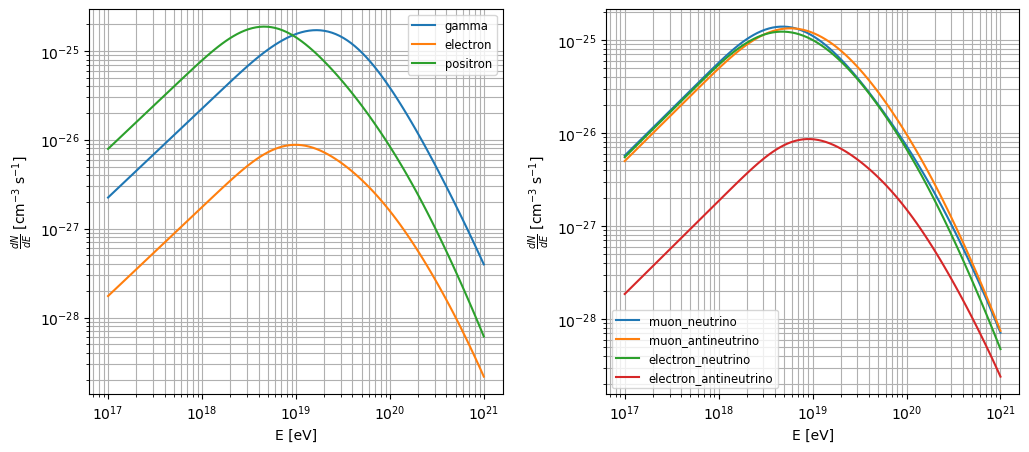

In [10]:
pmp_cmb = PhotoMesonProduction(blob, cmb_target)
E = np.logspace(17, 21, 100) * u.Unit("eV")
particles_left = ["gamma", "electron", "positron"]
particles_right = ["muon_neutrino", "muon_antineutrino", "electron_neutrino", "electron_antineutrino"]

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
fig.subplots_adjust(wspace = 0.25)
for particle in particles_left:
    spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
    plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[0])
    
for particle in particles_right:
    spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
    plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[1])

for ax in axs:
    ax.grid(which = "both")
    ax.legend(fontsize = "small")